# Human-Mammalian Brain Basal Ganglia 10X snRANSeq analysis: clustering and annotations

[Intro text]

You need to be connected to the internet to run this notebook or connected to a cache that has the HMBA-BG data downloaded already.

The notebook presented here shows quick visualizations from precomputed metadata in the atlas. For examples on accessing the expression matrices, specifically selecting genes from expression matrices, see the  ``general_acessing_10x_snRNASeq_tutorial.ipynb`` tutorial/example.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
test_data_base = Path('/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/hmba_bg_prep')
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20250131/manifest.json'

## Data overview
### Cell metadata

Essential cell metadata is stored as a CSV file that we load as a Pandas DataFrme. Each row represents one cell indexed by a *cell label*. The *cell label* is the concatenation of barcode and name of the sample. In this context, the sample is the *barcoded cell sample* that represents a single load into one port of the 10x Chromium. Note that cell barcodes are only unique within a single *barcoded cell sample* and that the same barcode can be reused. The *barcoded cell sample* label or name is unique in the database. This metadata file contains cells across all species in the HMBA-BG dataset.

Each cell is associated with a *library label*, *donor label*, *alignment_job_id*, *feature_matrix_label* and *dataset_label* identifying which data package this cell is part of. This metadata file will be combined with other metadata files that ship with this package to add information associated with the donor, UMAP coordinates, cluster assignments, and more.

Below, we load the first of the metadata used in this tutorial. This pattern of loading metadata is repeated throughout the tutorials.

In [3]:
# abc_cache.list_metadata_files('HMBA-10xMultiome-BG')

In [4]:
# abc_cache.list_metadata_files('HMBA-taxonomy-BG')

In [5]:
cell = pd.read_csv(
    test_data_base / "extracted/cell_metadata.csv",
    dtype={'cell_label': str}
)

"""
cell = abc_cache.get_metadata_dataframe(
    directory='WHB-10Xv3',
    file_name='cell_metadata',
    dtype={'cell_label': str}
)
"""
cell.set_index('cell_label', inplace=True)
print("Number of cells = ", len(cell))
cell.head(5)

Number of cells =  2522207


cell_barcode donor_label  \
cell_label                                                
AAACAGCCAAATGCCC-2362_A05  AAACAGCCAAATGCCC  H24.30.001   
AAACAGCCAATTGAGA-2362_A05  AAACAGCCAATTGAGA  H24.30.001   
AAACAGCCAGCATGTC-2362_A05  AAACAGCCAGCATGTC  H24.30.001   
AAACAGCCATTGACAT-2362_A05  AAACAGCCATTGACAT  H24.30.001   
AAACAGCCATTGTGGC-2362_A05  AAACAGCCATTGTGGC  H24.30.001   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAATTGAGA-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAGCATGTC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGACAT-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGTGGC-2362_A05                   2362_A05  L8XR_240808_01_E02   

                                                   alignment_job_id  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAATTGAGA-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAGCATGTC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGACAT-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGTGGC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   

                           doublet_score  umi_count  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05       0.027027      15259   
AAACAGCCAATTGAGA-2362_A05       0.054795      20645   
AAACAGCCAGCATGTC-2362_A05       0.000000       2551   
AAACAGCCATTGACAT-2362_A05       0.000000       2341   
AAACAGCCATTGTGGC-2362_A05       0.027397       8326   

                                feature_matrix_label        dataset_label  
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG  
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG  
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG  
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG  
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG

We can use pandas groupby function to see how many unique items are associated for each field and list them out if the number of items is small.

In [6]:
def print_column_info(df):
    
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c, len(grouped), members))

In [7]:
print_column_info(cell)

Number of unique cell_barcode = 711581 
Number of unique donor_label = 18 ['H18.30.001', 'H19.30.004', 'H20.30.001', 'H20.30.002', 'H21.30.004', 'H23.30.001', 'H24.30.001', 'H24.30.003', 'H24.30.004', 'H24.30.007', 'Q19.26.010', 'Q21.26.002', 'Q21.26.010', 'QM21.26.001', 'QM21.26.003', 'QM23.50.001', 'QM23.50.002', 'QM23.50.003']
Number of unique barcoded_cell_sample_label = 294 
Number of unique library_label = 294 
Number of unique alignment_job_id = 294 
Number of unique doublet_score = 2581 
Number of unique umi_count = 120559 
Number of unique feature_matrix_label = 2 ['HMBA-10xMultiome-BG-Human', 'HMBA-10xMultiome-BG-Macaque']
Number of unique dataset_label = 1 ['HMBA-10xMultiome-BG']


Below we use a pandas group by to show the number of cells from each feature matrix. This shows the number of cells from each species in the HMBA Basal Ganglia dataset.

In [8]:
cell.groupby('feature_matrix_label')[['doublet_score']].count()

doublet_score
feature_matrix_label                      
HMBA-10xMultiome-BG-Human          1683105
HMBA-10xMultiome-BG-Macaque         839102

### Donor and Library metadata

The first two associated metadata we load are the `donor` and `library` tables. The donor table contains species, sex, and age information. The library table contains information on 10X methods and brain region of interest the tissue was extracted from.

In [9]:
donor = pd.read_csv(
    test_data_base / "extracted/donor.csv"
).set_index('donor_label')
donor.head()

donor_species species_scientific_name species_common_name  \
donor_label                                                               
QM23.50.003  NCBITaxon:9544          Macaca mulatta             Macaque   
QM21.26.001  NCBITaxon:9544          Macaca mulatta             Macaque   
Q19.26.010   NCBITaxon:9544          Macaca mulatta             Macaque   
H24.30.003   NCBITaxon:9606            Homo sapiens               Human   
H21.30.004   NCBITaxon:9606            Homo sapiens               Human   

            donor_sex donor_age  donor_age_value donor_age_unit  
donor_label                                                      
QM23.50.003      Male     6 yrs                6          years  
QM21.26.001      Male     6 yrs                6          years  
Q19.26.010     Female    10 yrs               10          years  
H24.30.003     Female    19 yrs               19          years  
H21.30.004       Male    57 yrs               57          years

In [10]:
library = pd.read_csv(
    test_data_base / "extracted/library.csv"
).set_index('library_label')
library.head()

library_method barcoded_cell_sample_label  \
library_label                                                    
L8XR_240222_21_H03  10xMultiome;GEX                   2077_A02   
L8XR_220428_02_A05  10xMultiome;GEX                   1224_A04   
L8XR_220428_02_C04  10xMultiome;GEX                   1222_A02   
L8XR_240705_01_A06  10xMultiome;GEX                   2305_E01   
L8XR_240919_21_B05  10xMultiome;GEX                   2453_A02   

                                            enrichment_population  \
library_label                                                       
L8XR_240222_21_H03              50% NeuN+, 35% OLIG2-, 15% OLIG2+   
L8XR_220428_02_A05  10% NeuN+, 49% OLIG2-, 25% OLIG2+, 16% Nurr1+   
L8XR_220428_02_C04              60% NeuN+, 27% OLIG2-, 13% OLIG2+   
L8XR_240705_01_A06              50% NeuN+, 35% OLIG2-, 15% OLIG2+   
L8XR_240919_21_B05              70% NeuN+, 20% OLIG2-, 10% OLIG2+   

                   cell_specimen_type parcellation_term_identifier  \
library_label                                                        
L8XR_240222_21_H03             Nuclei                   DHBA:11538   
L8XR_220428_02_A05             Nuclei                   DHBA:12261   
L8XR_220428_02_C04             Nuclei                   DHBA:10466   
L8XR_240705_01_A06             Nuclei                   DHBA:11537   
L8XR_240919_21_B05             Nuclei                   DHBA:10345   

                   region_of_interest_name region_of_interest_label  \
library_label                                                         
L8XR_240222_21_H03          caudal putamen                      PuC   
L8XR_220428_02_A05  ventral tegmental area                      VTA   
L8XR_220428_02_C04     subthalamic nucleus                      STH   
L8XR_240705_01_A06         rostral putamen                      PuR   
L8XR_240919_21_B05        Ventral pallidus                      VeP   

                   anatomical_division_label  donor_label  
library_label                                              
L8XR_240222_21_H03             Basal ganglia  QM23.50.003  
L8XR_220428_02_A05             Basal ganglia  QM21.26.001  
L8XR_220428_02_C04             Basal ganglia   Q19.26.010  
L8XR_240705_01_A06             Basal ganglia   H24.30.003  
L8XR_240919_21_B05             Basal ganglia   H21.30.004

We combine these into an extended cell metadata table.

In [11]:
cell_extended = cell.join(donor, on='donor_label')
cell_extended = cell_extended.join(library, on='library_label', rsuffix='_library_table')

### Adding color and feature order

Each feature in the donor and library table comes is associated with unique colors and an ordering with the set of values. Below we load the mapping and incorporate these values into the cell metadata table. 

In [12]:
value_sets = pd.read_csv(
    test_data_base / "extracted/value_sets.csv"
).set_index('label')
value_sets.head()

table                    field        description  order  \
label                                                                         
Human              donor      species_common_name              Human      1   
Macaque            donor      species_common_name            Macaque      2   
Homo sapiens       donor  species_scientific_name       Homo sapiens      1   
Macaca mulatta     donor  species_scientific_name     Macaca mulatta      2   
Macaca nemestrina  donor  species_scientific_name  Macaca nemestrina      3   

                  external_identifier parent_label color_hex_triplet  
label                                                                 
Human                             NaN          NaN           #377eb8  
Macaque                           NaN          NaN           #4daf4a  
Homo sapiens           NCBITaxon:9606          NaN           #377eb8  
Macaca mulatta         NCBITaxon:9544          NaN           #4daf4a  
Macaca nemestrina      NCBITaxon:9545          NaN           #b2df8a

In [13]:
# Add region of interest color and order.
cell_extended['region_of_interest_label_color'] = value_sets[
    value_sets['table'] == 'library'
].loc[cell_extended['region_of_interest_label']]['color_hex_triplet'].values
cell_extended['region_of_interest_label_order'] = value_sets[
    value_sets['table'] == 'library'
].loc[cell_extended['region_of_interest_label']]['order'].values

# Add speices scientific name color and order.
cell_extended['species_scientific_name_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_scientific_name']]['color_hex_triplet'].values
cell_extended['species_scientific_name_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_scientific_name']]['order'].values

# Add speices common name color and order.
cell_extended['species_common_name_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_common_name']]['color_hex_triplet'].values
cell_extended['species_common_name_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['species_common_name']]['order'].values

# Add donor sex color and order.
cell_extended['donor_sex_color'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['donor_sex']]['color_hex_triplet'].values
cell_extended['donor_sex_order'] = value_sets[
    value_sets['table'] == 'donor'
].loc[cell_extended['donor_sex']]['order'].values
cell_extended.head()

cell_barcode donor_label  \
cell_label                                                
AAACAGCCAAATGCCC-2362_A05  AAACAGCCAAATGCCC  H24.30.001   
AAACAGCCAATTGAGA-2362_A05  AAACAGCCAATTGAGA  H24.30.001   
AAACAGCCAGCATGTC-2362_A05  AAACAGCCAGCATGTC  H24.30.001   
AAACAGCCATTGACAT-2362_A05  AAACAGCCATTGACAT  H24.30.001   
AAACAGCCATTGTGGC-2362_A05  AAACAGCCATTGTGGC  H24.30.001   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAATTGAGA-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAGCATGTC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGACAT-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGTGGC-2362_A05                   2362_A05  L8XR_240808_01_E02   

                                                   alignment_job_id  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAATTGAGA-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAGCATGTC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGACAT-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGTGGC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   

                           doublet_score  umi_count  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05       0.027027      15259   
AAACAGCCAATTGAGA-2362_A05       0.054795      20645   
AAACAGCCAGCATGTC-2362_A05       0.000000       2551   
AAACAGCCATTGACAT-2362_A05       0.000000       2341   
AAACAGCCATTGTGGC-2362_A05       0.027397       8326   

                                feature_matrix_label        dataset_label  \
cell_label                                                                  
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   

                            donor_species  ... anatomical_division_label  \
cell_label                                 ...                             
AAACAGCCAAATGCCC-2362_A05  NCBITaxon:9606  ...             Basal ganglia   
AAACAGCCAATTGAGA-2362_A05  NCBITaxon:9606  ...             Basal ganglia   
AAACAGCCAGCATGTC-2362_A05  NCBITaxon:9606  ...             Basal ganglia   
AAACAGCCATTGACAT-2362_A05  NCBITaxon:9606  ...             Basal ganglia   
AAACAGCCATTGTGGC-2362_A05  NCBITaxon:9606  ...             Basal ganglia   

                          donor_label_library_table  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05                H24.30.001   
AAACAGCCAATTGAGA-2362_A05                H24.30.001   
AAACAGCCAGCATGTC-2362_A05                H24.30.001   
AAACAGCCATTGACAT-2362_A05                H24.30.001   
AAACAGCCATTGTGGC-2362_A05                H24.30.001   

                          region_of_interest_label_color  \
cell_label                                                 
AAACAGCCAAATGCCC-2362_A05                        #D7E0BF   
AAACAGCCAATTGAGA-2362_A05                        #D7E0BF   
AAACAGCCAGCATGTC-2362_A05                        #D7E0BF   
AAACAGCCATTGACAT-2362_A05                        #D7E0BF   
AAACAGCCATTGTGGC-2362_A05                        #D7E0BF   

                          region_of_interest_label_order  \
cell_label                                                 
AAACAGCCAAATGCCC-2362_A05                             14   
AAACAGCCAATTGAGA-2362_A05                             14   
AAACAGCCAGCATGTC-2362_A05                             14   
AAACAGCCATTGACAT-236

### UMAP spatial embedding

Now that we've merged our donor and library metadata into the main cells data, our next step is to put these values in a Uniform Manifold Approximation and Projection (UMAP) for cells in the dataset. The UMAP is a dimension reduction technique that can be used for visualizing and exploring large-dimension datasets. 

Below we load this 2-D embedding for a sub selection of our cells and merge the x-y coordinates into the extended cell metadata we are creating. 

In [14]:
cell_2d_embedding_coordinates = pd.read_csv(
    test_data_base / "HBMA-BG-taxonomy-CCN20241031/cell_2d_embedding_coordinates.csv"
).set_index('cell_label')
cell_2d_embedding_coordinates.head()

x          y
cell_label                                     
AAACAGCCAAATGCCC-1091_A05   6.972323  15.434034
AAACAGCCACACAATT-1091_A05  12.874631   5.735814
AAACAGCCAGCACGAA-1091_A05  12.788229   7.095924
AAACATGCAGCCAGTT-1091_A05  11.433255   5.756390
AAACATGCATAGTCAT-1091_A05  12.082458   5.616303

In [15]:
cell_extended = cell_extended.join(cell_2d_embedding_coordinates)

We define a small helper function *plot umap* to visualize the cells on the UMAP. In the examples below we will plot associated cell information colorized by dissection donor species, sex, and region of interest.

In [16]:
def plot_umap(
    xx,
    yy,
    cc=None,
    val=None,
    fig_width=8,
    fig_height=8,
    cmap=None,
    labels=None,
    term_orders=None,
    colorbar=False,
    sizes=None
):
    """
    """
    if sizes is None:
        sizes = 1
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None:
        scatt = ax.scatter(xx, yy, c=val, s=0.5, marker='.', cmap=cmap, alpha=sizes)
    elif cc is not None:
        scatt = ax.scatter(xx, yy, c=cc, s=0.5, marker='.', alpha=sizes)

    if labels is not None:
        from matplotlib.patches import Rectangle
        unique_label_colors = (labels + ',' + cc).unique()
        unique_labels = np.array([label_color.split(',')[0] for label_color in unique_label_colors])
        unique_colors = np.array([label_color.split(',')[1] for label_color in unique_label_colors])

        if term_orders is not None:
            unique_order = term_orders.unique()
            term_order = np.argsort(unique_order)
            unique_labels = unique_labels[term_order]
            unique_colors = unique_colors[term_order]
            
        rects = []
        for color in unique_colors:
            rects.append(Rectangle((0, 0), 1, 1, fc=color))

        legend = ax.legend(rects, unique_labels, loc=1)
        # ax.add_artist(legend)

    if colorbar:
        fig.colorbar(scatt, ax=ax)
    
    return fig, ax

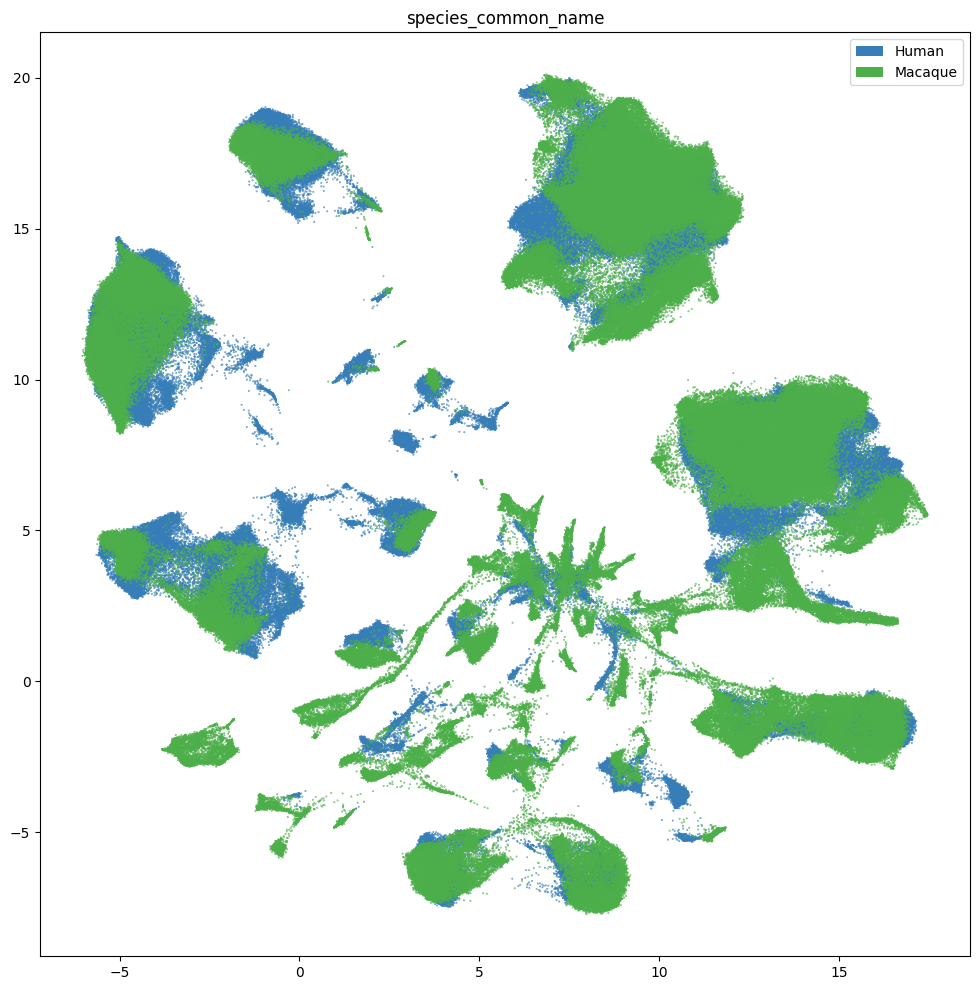

In [17]:
cell_with_umap = cell_extended[~pd.isna(cell_extended['x'])]
fig, ax = plot_umap(
    cell_with_umap['x'],
    cell_with_umap['y'],
    cc=cell_with_umap['species_common_name_color'],
    labels=cell_with_umap['species_common_name'],
    term_orders=cell_with_umap['species_common_name_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("species_common_name")
plt.show()

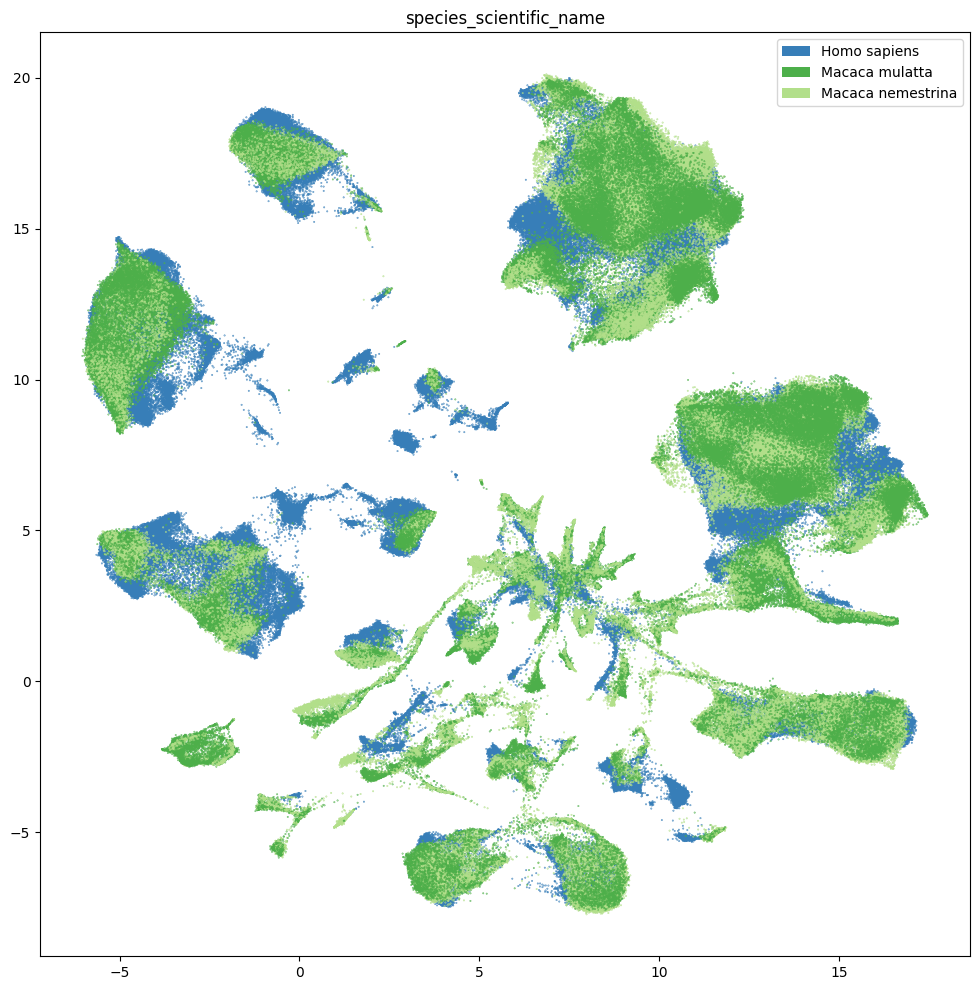

In [18]:
fig, ax = plot_umap(
    cell_with_umap['x'],
    cell_with_umap['y'],
    cc=cell_with_umap['species_scientific_name_color'],
    labels=cell_with_umap['species_scientific_name'],
    term_orders=cell_with_umap['species_scientific_name_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("species_scientific_name")
plt.show()

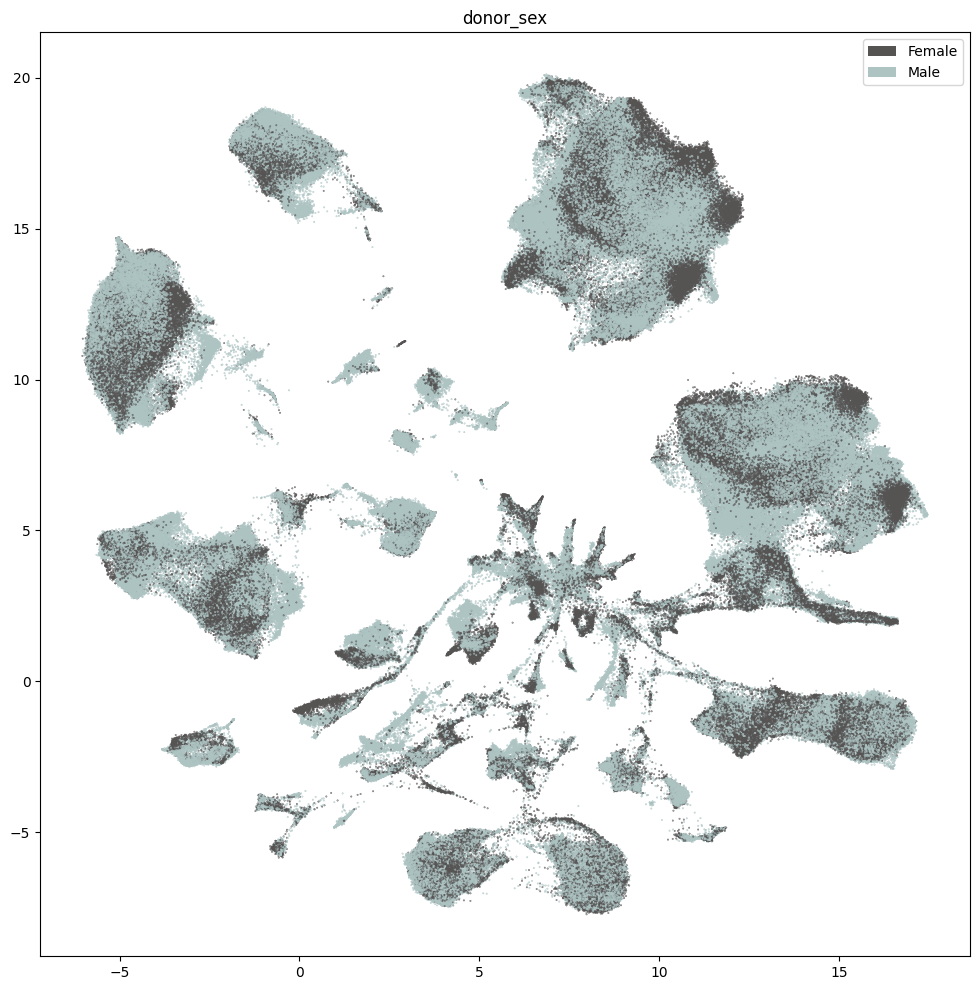

In [19]:
fig, ax = plot_umap(
    cell_with_umap['x'],
    cell_with_umap['y'],
    cc=cell_with_umap['donor_sex_color'],
    labels=cell_with_umap['donor_sex'],
    term_orders=cell_with_umap['donor_sex_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("donor_sex")
plt.show()

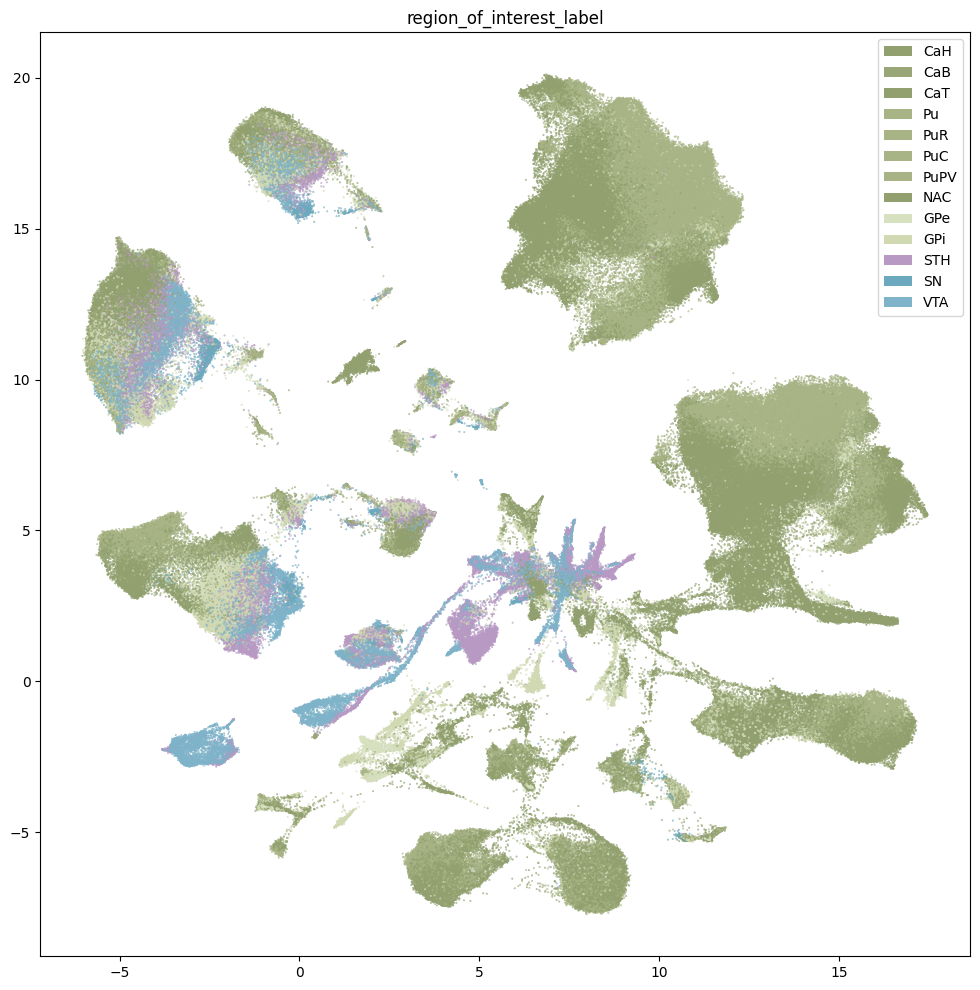

In [20]:
fig, ax = plot_umap(
    cell_with_umap['x'],
    cell_with_umap['y'],
    cc=cell_with_umap['region_of_interest_label_color'],
    labels=cell_with_umap['region_of_interest_label'],
    term_orders=cell_with_umap['region_of_interest_label_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("region_of_interest_label")
plt.show()

## Taxonomy Information

The final set of metadata we load into our extended cell metadata file maps the cells into their assigned cluster in the taxonomy. We additionally load metadata regarding the clusters and compute useful information, such as the number of cells in each taxon at each level of the taxonomy.

First, we load the table that describes the levels in the taxonomy from Neighborhood at the highest to Cluster at the lowest level.

In [21]:
cluster_annotation_term_set = pd.read_csv(
    test_data_base / "HBMA-BG-taxonomy-CCN20241031/cluster_annotation_term_set.csv"
).rename(columns={'label': 'cluster_annotation_term_label'})
cluster_annotation_term_set

cluster_annotation_term_label          name   description  order
0           CCN20241031_LEVEL_0  Neighborhood  Neighborhood      0
1           CCN20241031_LEVEL_1         Class         Class      1
2           CCN20241031_LEVEL_2      Subclass      Subclass      2
3           CCN20241031_LEVEL_3         Group         Group      3
4           CCN20241031_LEVEL_4       Cluster       Cluster      4

Next, we load information associated with each Cluster in the taxonomy. This includes a useful alias value for each cluster as well as the number of cells in each cluster.

In [22]:
cluster = pd.read_csv(
    test_data_base / "HBMA-BG-taxonomy-CCN20241031/cluster.csv",
    dtype={'number_of_cells': 'Int64'}
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster.head()

cluster_alias  number_of_cells
cluster_annotation_term_label                                
CS20241031_CLUST_0000                      0               95
CS20241031_CLUST_0001                      1              302
CS20241031_CLUST_0002                      2              178
CS20241031_CLUST_0003                      3              276
CS20241031_CLUST_0004                      4              206

Finally, for the clusters, we load information on the annotations for each cluster. This also includes the term order and color information which we will use to plot later.

In [23]:
cluster_annotation_term = pd.read_csv(
    test_data_base / "HBMA-BG-taxonomy-CCN20241031/cluster_annotation_term.csv"
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster_annotation_term.head()

name  \
cluster_annotation_term_label                    
CS20241031_NEIGH_0000          Subpallium GABA   
CS20241031_NEIGH_0001           Glut Sero Dopa   
CS20241031_NEIGH_0002                GABA Glut   
CS20241031_NEIGH_0003                Nonneuron   
CS20241031_CLASS_0000              CN MGE GABA   

                              cluster_annotation_term_set_label  \
cluster_annotation_term_label                                     
CS20241031_NEIGH_0000                       CCN20241031_LEVEL_0   
CS20241031_NEIGH_0001                       CCN20241031_LEVEL_0   
CS20241031_NEIGH_0002                       CCN20241031_LEVEL_0   
CS20241031_NEIGH_0003                       CCN20241031_LEVEL_0   
CS20241031_CLASS_0000                       CCN20241031_LEVEL_1   

                                   parent_term_label parent_term_set_label  \
cluster_annotation_term_label                                                
CS20241031_NEIGH_0000                            NaN                   NaN   
CS20241031_NEIGH_0001                            NaN                   NaN   
CS20241031_NEIGH_0002                            NaN                   NaN   
CS20241031_NEIGH_0003                            NaN                   NaN   
CS20241031_CLASS_0000          CS20241031_NEIGH_0000   CCN20241031_LEVEL_0   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20241031_NEIGH_0000                             Neighborhood   
CS20241031_NEIGH_0001                             Neighborhood   
CS20241031_NEIGH_0002                             Neighborhood   
CS20241031_NEIGH_0003                             Neighborhood   
CS20241031_CLASS_0000                                    Class   

                              color_hex_triplet  term_order  term_set_order  
cluster_annotation_term_label                                                
CS20241031_NEIGH_0000                   #8000FF           0               0  
CS20241031_NEIGH_0001                   #85CC3D           1               0  
CS20241031_NEIGH_0002                   #FF7373           2               0  
CS20241031_NEIGH_0003                   #179999           3               0  
CS20241031_CLASS_0000                   #5CCC89           0               1

We merge this table with information from our clusters.

In [24]:
cluster_annotation_term_with_cells = cluster_annotation_term.join(cluster)

While we have information on the number of cells in each cluster, we need to sum these to get the number of cells in each of the upper levels of the taxonomy. Below we iterate through each level from the lowest to highest, summing the number of cells as we go.

In [25]:
for cluster_annotation_term_label in reversed(sorted(cluster_annotation_term_with_cells['cluster_annotation_term_set_label'].unique())):
    sub_terms = cluster_annotation_term_with_cells[
        cluster_annotation_term_with_cells['cluster_annotation_term_set_label'] == cluster_annotation_term_label
    ]
    parents = sub_terms['parent_term_label'].unique()
    for parent in parents:
        if pd.isna(parent):
            continue
        n_cells = sub_terms[
            sub_terms['parent_term_label'] == parent
        ]['number_of_cells'].sum()
        cluster_annotation_term_with_cells.loc[parent, 'number_of_cells'] = n_cells
cluster_annotation_term_with_cells.head()

name  \
cluster_annotation_term_label                    
CS20241031_NEIGH_0000          Subpallium GABA   
CS20241031_NEIGH_0001           Glut Sero Dopa   
CS20241031_NEIGH_0002                GABA Glut   
CS20241031_NEIGH_0003                Nonneuron   
CS20241031_CLASS_0000              CN MGE GABA   

                              cluster_annotation_term_set_label  \
cluster_annotation_term_label                                     
CS20241031_NEIGH_0000                       CCN20241031_LEVEL_0   
CS20241031_NEIGH_0001                       CCN20241031_LEVEL_0   
CS20241031_NEIGH_0002                       CCN20241031_LEVEL_0   
CS20241031_NEIGH_0003                       CCN20241031_LEVEL_0   
CS20241031_CLASS_0000                       CCN20241031_LEVEL_1   

                                   parent_term_label parent_term_set_label  \
cluster_annotation_term_label                                                
CS20241031_NEIGH_0000                            NaN                   NaN   
CS20241031_NEIGH_0001                            NaN                   NaN   
CS20241031_NEIGH_0002                            NaN                   NaN   
CS20241031_NEIGH_0003                            NaN                   NaN   
CS20241031_CLASS_0000          CS20241031_NEIGH_0000   CCN20241031_LEVEL_0   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20241031_NEIGH_0000                             Neighborhood   
CS20241031_NEIGH_0001                             Neighborhood   
CS20241031_NEIGH_0002                             Neighborhood   
CS20241031_NEIGH_0003                             Neighborhood   
CS20241031_CLASS_0000                                    Class   

                              color_hex_triplet  term_order  term_set_order  \
cluster_annotation_term_label                                                 
CS20241031_NEIGH_0000                   #8000FF           0               0   
CS20241031_NEIGH_0001                   #85CC3D           1               0   
CS20241031_NEIGH_0002                   #FF7373           2               0   
CS20241031_NEIGH_0003                   #179999           3               0   
CS20241031_CLASS_0000                   #5CCC89           0               1   

                               cluster_alias  number_of_cells  
cluster_annotation_term_label                                  
CS20241031_NEIGH_0000                    NaN           458635  
CS20241031_NEIGH_0001                    NaN            22134  
CS20241031_NEIGH_0002                    NaN              509  
CS20241031_NEIGH_0003                    NaN           225699  
CS20241031_CLASS_0000                    NaN            78954

Finally, we load the cluster to cluster annotation membership table to help us create associated metadata for each cluster to tell us the annotations for a given Cluster at all levels of the taxonomy. We'll use this in groupbys to give each cluster the metadata for each of its parents. This will be useful when we merge into the cell metadata table.

In [26]:
cluster_to_cluster_annotation_membership = pd.read_csv(
    test_data_base / "HBMA-BG-taxonomy-CCN20241031/cluster_to_cluster_annotation_membership.csv"
).set_index('cluster_annotation_term_label')
membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(cluster_annotation_term_with_cells, rsuffix='_anno_term').reset_index()
"""
cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='WHB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
)"""
membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)
membership_with_cluster_info.head()

cluster_annotation_term_label cluster_annotation_term_set_label  \
0         CS20241031_NEIGH_0000               CCN20241031_LEVEL_0   
1         CS20241031_CLASS_0001               CCN20241031_LEVEL_1   
2         CS20241031_SUBCL_0001               CCN20241031_LEVEL_2   
3         CS20241031_GROUP_0002               CCN20241031_LEVEL_3   
4         CS20241031_CLUST_0201               CCN20241031_LEVEL_4   

   cluster_alias cluster_annotation_term_set_name  \
0            201                     Neighborhood   
1            201                            Class   
2            201                         Subclass   
3            201                            Group   
4            201                          Cluster   

  cluster_annotation_term_name             name  \
0              Subpallium GABA  Subpallium GABA   
1                  CN LGE GABA      CN LGE GABA   
2              STR D2 MSN GABA  STR D2 MSN GABA   
3                STRv D2 Shell    STRv D2 Shell   
4              Human-MSN_7_1_2  Human-MSN_7_1_2   

  cluster_annotation_term_set_label_anno_term      parent_term_label  \
0                         CCN20241031_LEVEL_0                    NaN   
1                         CCN20241031_LEVEL_1  CS20241031_NEIGH_0000   
2                         CCN20241031_LEVEL_2  CS20241031_CLASS_0001   
3                         CCN20241031_LEVEL_3  CS20241031_SUBCL_0001   
4                         CCN20241031_LEVEL_4  CS20241031_GROUP_0002   

  parent_term_set_label cluster_annotation_term_set_name_anno_term  \
0                   NaN                               Neighborhood   
1   CCN20241031_LEVEL_0                                      Class   
2   CCN20241031_LEVEL_1                                   Subclass   
3   CCN20241031_LEVEL_2                                      Group   
4   CCN20241031_LEVEL_3                                    Cluster   

  color_hex_triplet  term_order  term_set_order  cluster_alias_anno_term  \
0           #8000FF           0               0                      NaN   
1           #33FF00           1               1                      NaN   
2           #B53DCC           1               2                      NaN   
3           #990048           2               3                      NaN   
4           #4E4DFF         201               4                    201.0   

   number_of_cells  
0           458635  
1           375846  
2           175545  
3            28728  
4             9164

From the membership table, create three tables, first the name of each cluster and its parents.

In [27]:
# term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_details = cluster_details[cluster_annotation_term_set['name']] # order columns
cluster_details.fillna('Other', inplace=True)
cluster_details.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_details.head()

cluster_annotation_term_set_name    Neighborhood         Class      Subclass  \
cluster_alias                                                                  
67                                     GABA Glut  BG GABA Glut  GP GABA Glut   
523                                    GABA Glut  BG GABA Glut  GP GABA Glut   
524                                    GABA Glut  BG GABA Glut  GP GABA Glut   
88                                Glut Sero Dopa      F M Glut       BG Glut   
89                                Glut Sero Dopa      F M Glut       BG Glut   

cluster_annotation_term_set_name          Group         Cluster  
cluster_alias                                                    
67                                    GPi Shell     Human-IN_54  
523                                   GPi Shell  Macaque-IN_181  
524                                   GPi Shell  Macaque-IN_182  
88                                BG SKOR1 Glut     Human-IN_74  
89                                BG SKOR1 Glut     Human-IN_75

Next the plotting order of each of the cluster and its parents.

In [28]:
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_order.rename(
    columns={'Neighborhood': 'Neighborhood_order',
             'Class': 'Class_order',
             'Subclass': 'Subclass_order',
             'Group': 'Group_order',
             'Cluster': 'Cluster_order'},
    inplace=True
)
cluster_order.head()

cluster_annotation_term_set_name  Class_order  Cluster_order  Group_order  \
cluster_alias                                                               
18                                          0             18           34   
19                                          0             19           34   
20                                          0             20           34   
22                                          0             22           34   
23                                          0             23           34   

cluster_annotation_term_set_name  Neighborhood_order  Subclass_order  
cluster_alias                                                         
18                                                 0               4  
19                                                 0               4  
20                                                 0               4  
22                                                 0               4  
23                                                 0               4

Finally, the colors we will use to plot for each of the unique taxons at all levels.

In [29]:
cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_colors.head()

cluster_annotation_term_set_name Neighborhood    Class Subclass    Group  \
cluster_alias                                                              
236                                   #179999  #267DFF  #00FFE6  #459917   
318                                   #179999  #267DFF  #00FFE6  #459917   
238                                   #179999  #267DFF  #00FFE6  #459917   
370                                   #179999  #267DFF  #179973  #FF7373   
259                                   #179999  #267DFF  #179973  #FF7373   

cluster_annotation_term_set_name  Cluster  
cluster_alias                              
236                               #804599  
318                               #99572E  
238                               #A01FCC  
370                               #9CFF4D  
259                               #CC00AB

Next, we bring it all together by loading the mapping of cells to cluster and join into our final metadata table. Note here that not every cell is currently associated into the taxonomy hence the NaN values for many of the taxonomy information columns.

In [30]:
cell_to_cluster_membership = pd.read_csv(
    test_data_base / "HBMA-BG-taxonomy-CCN20241031/cell_to_cluster_membership.csv"
).set_index('cell_label')
cell_to_cluster_membership.head()

cluster_alias          cluster_label
cell_label                                                     
AAACAGCCAAATGCCC-1091_A05            201  CS20241031_CLUST_0201
AAACAGCCACACAATT-1091_A05            223  CS20241031_CLUST_0223
AAACAGCCAGCACGAA-1091_A05            205  CS20241031_CLUST_0205
AAACATGCAGCCAGTT-1091_A05            113  CS20241031_CLUST_0113
AAACATGCATAGTCAT-1091_A05            223  CS20241031_CLUST_0223

In [31]:
cell_extended = cell_extended.join(cell_to_cluster_membership, rsuffix='_cell_to_cluster_membership')
cell_extended = cell_extended.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(cluster_order, on='cluster_alias')
cell_extended.head()

cell_barcode donor_label  \
cell_label                                                
AAACAGCCAAATGCCC-2362_A05  AAACAGCCAAATGCCC  H24.30.001   
AAACAGCCAATTGAGA-2362_A05  AAACAGCCAATTGAGA  H24.30.001   
AAACAGCCAGCATGTC-2362_A05  AAACAGCCAGCATGTC  H24.30.001   
AAACAGCCATTGACAT-2362_A05  AAACAGCCATTGACAT  H24.30.001   
AAACAGCCATTGTGGC-2362_A05  AAACAGCCATTGTGGC  H24.30.001   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
AAACAGCCAAATGCCC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAATTGAGA-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCAGCATGTC-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGACAT-2362_A05                   2362_A05  L8XR_240808_01_E02   
AAACAGCCATTGTGGC-2362_A05                   2362_A05  L8XR_240808_01_E02   

                                                   alignment_job_id  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAATTGAGA-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCAGCATGTC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGACAT-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   
AAACAGCCATTGTGGC-2362_A05  8a4bf81821a0f425be8ba9c15dfad6b509020312   

                           doublet_score  umi_count  \
cell_label                                            
AAACAGCCAAATGCCC-2362_A05       0.027027      15259   
AAACAGCCAATTGAGA-2362_A05       0.054795      20645   
AAACAGCCAGCATGTC-2362_A05       0.000000       2551   
AAACAGCCATTGACAT-2362_A05       0.000000       2341   
AAACAGCCATTGTGGC-2362_A05       0.027397       8326   

                                feature_matrix_label        dataset_label  \
cell_label                                                                  
AAACAGCCAAATGCCC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCAATTGAGA-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCAGCATGTC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCATTGACAT-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   
AAACAGCCATTGTGGC-2362_A05  HMBA-10xMultiome-BG-Human  HMBA-10xMultiome-BG   

                            donor_species  ... Neighborhood_color Class_color  \
cell_label                                 ...                                  
AAACAGCCAAATGCCC-2362_A05  NCBITaxon:9606  ...                NaN         NaN   
AAACAGCCAATTGAGA-2362_A05  NCBITaxon:9606  ...                NaN         NaN   
AAACAGCCAGCATGTC-2362_A05  NCBITaxon:9606  ...                NaN         NaN   
AAACAGCCATTGACAT-2362_A05  NCBITaxon:9606  ...                NaN         NaN   
AAACAGCCATTGTGGC-2362_A05  NCBITaxon:9606  ...                NaN         NaN   

                          Subclass_color Group_color  Cluster_color  \
cell_label                                                            
AAACAGCCAAATGCCC-2362_A05            NaN         NaN            NaN   
AAACAGCCAATTGAGA-2362_A05            NaN         NaN            NaN   
AAACAGCCAGCATGTC-2362_A05            NaN         NaN            NaN   
AAACAGCCATTGACAT-2362_A05            NaN         NaN            NaN   
AAACAGCCATTGTGGC-2362_A05            NaN         NaN            NaN   

                          Class_order Cluster_order Group_order  \
cell_label                                                        
AAACAGCCAAATGCCC-2362_A05         NaN           NaN         NaN   
AAACAGCCAATTGAGA-2362_A05         NaN           NaN         NaN   
AAACAGCCAGCATGTC-2362_A05         NaN           NaN         NaN   
AAACAGCCATTGACAT-2362_A05         NaN           NaN         NaN   
AAACAGCCATTGTGGC-2362_A05         NaN           NaN         NaN   

                          Neighborhood_order Subclass_order  
cell_label                                                   


In [32]:
print_column_info(cell_extended)

Number of unique cell_barcode = 711581 
Number of unique donor_label = 18 ['H18.30.001', 'H19.30.004', 'H20.30.001', 'H20.30.002', 'H21.30.004', 'H23.30.001', 'H24.30.001', 'H24.30.003', 'H24.30.004', 'H24.30.007', 'Q19.26.010', 'Q21.26.002', 'Q21.26.010', 'QM21.26.001', 'QM21.26.003', 'QM23.50.001', 'QM23.50.002', 'QM23.50.003']
Number of unique barcoded_cell_sample_label = 294 
Number of unique library_label = 294 
Number of unique alignment_job_id = 294 
Number of unique doublet_score = 2581 
Number of unique umi_count = 120559 
Number of unique feature_matrix_label = 2 ['HMBA-10xMultiome-BG-Human', 'HMBA-10xMultiome-BG-Macaque']
Number of unique dataset_label = 1 ['HMBA-10xMultiome-BG']
Number of unique donor_species = 3 ['NCBITaxon:9544', 'NCBITaxon:9545', 'NCBITaxon:9606']
Number of unique species_scientific_name = 3 ['Homo sapiens', 'Macaca mulatta', 'Macaca nemestrina']
Number of unique species_common_name = 2 ['Human', 'Macaque']
Number of unique donor_sex = 2 ['Female', 'Male

#### Plotting the taxonomy

Now that we have our cells with associated taxonomy information, we'll plot them into the UMAP we showed previously. First, we trim down the cells to those with taxonomy information by selecting those that where the taxonomy information is not NaN.

In [33]:
cell_with_taxonomy = cell_extended[~pd.isna(cell_extended['Class_color'])]

Below we plot the taxonomy mapping of the cells for each level in the taxonomy.

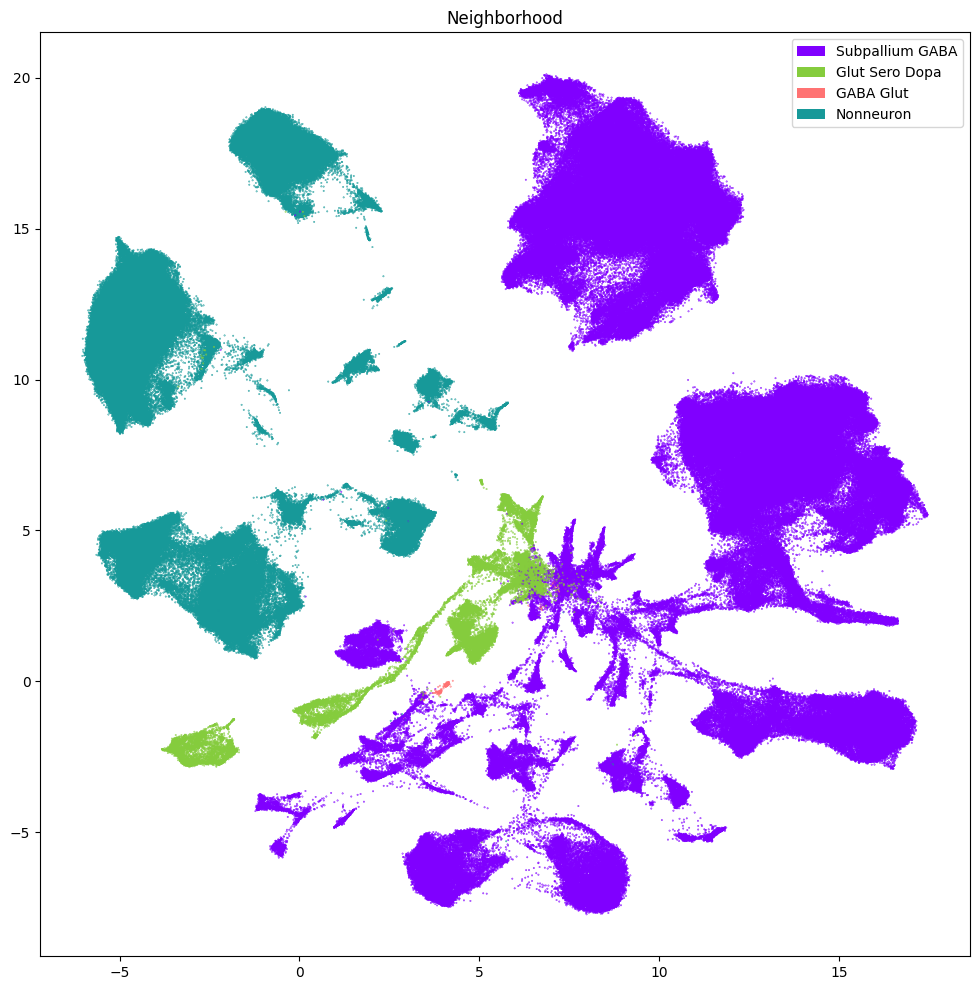

In [34]:
fig, ax = plot_umap(
    cell_with_taxonomy['x'],
    cell_with_taxonomy['y'],
    cc=cell_with_taxonomy['Neighborhood_color'],
    labels=cell_with_taxonomy['Neighborhood'],
    term_orders=cell_with_taxonomy['Neighborhood_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Neighborhood")
plt.show()

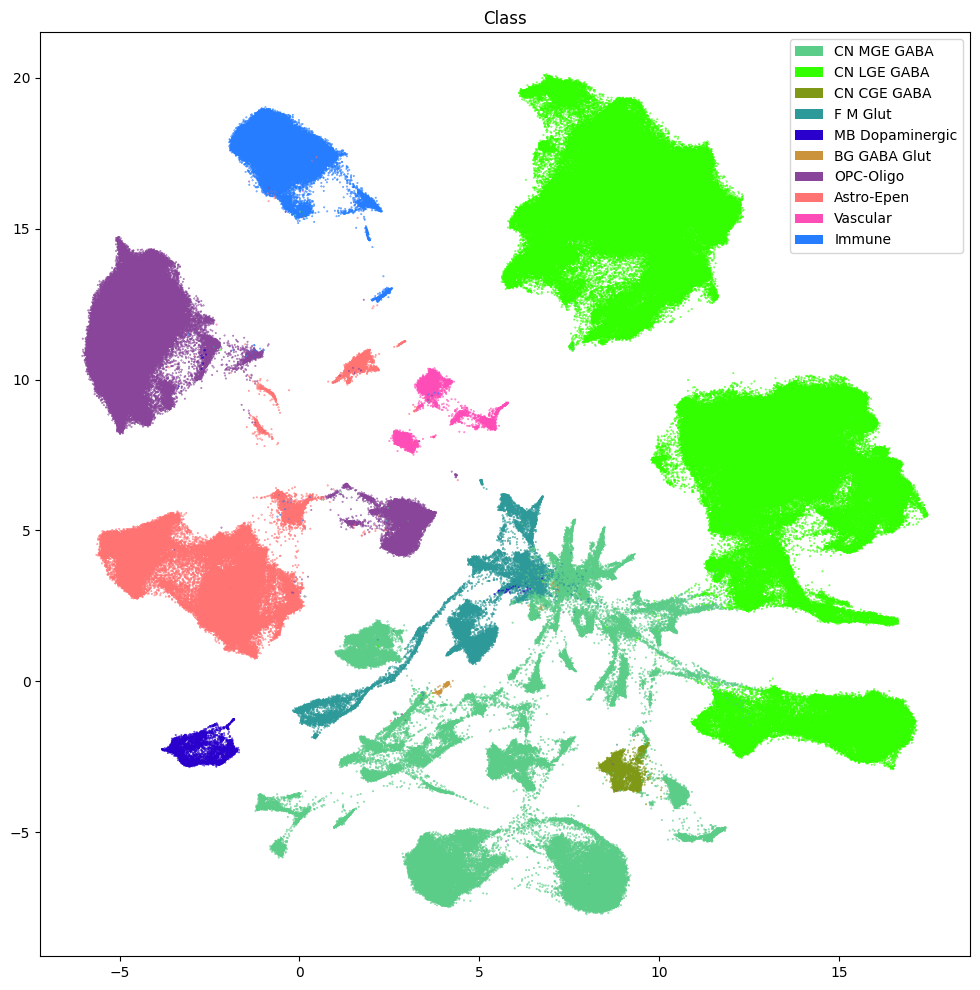

In [35]:
fig, ax = plot_umap(
    cell_with_taxonomy['x'],
    cell_with_taxonomy['y'],
    cc=cell_with_taxonomy['Class_color'],
    labels=cell_with_taxonomy['Class'],
    term_orders=cell_with_taxonomy['Class_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Class")
plt.show()

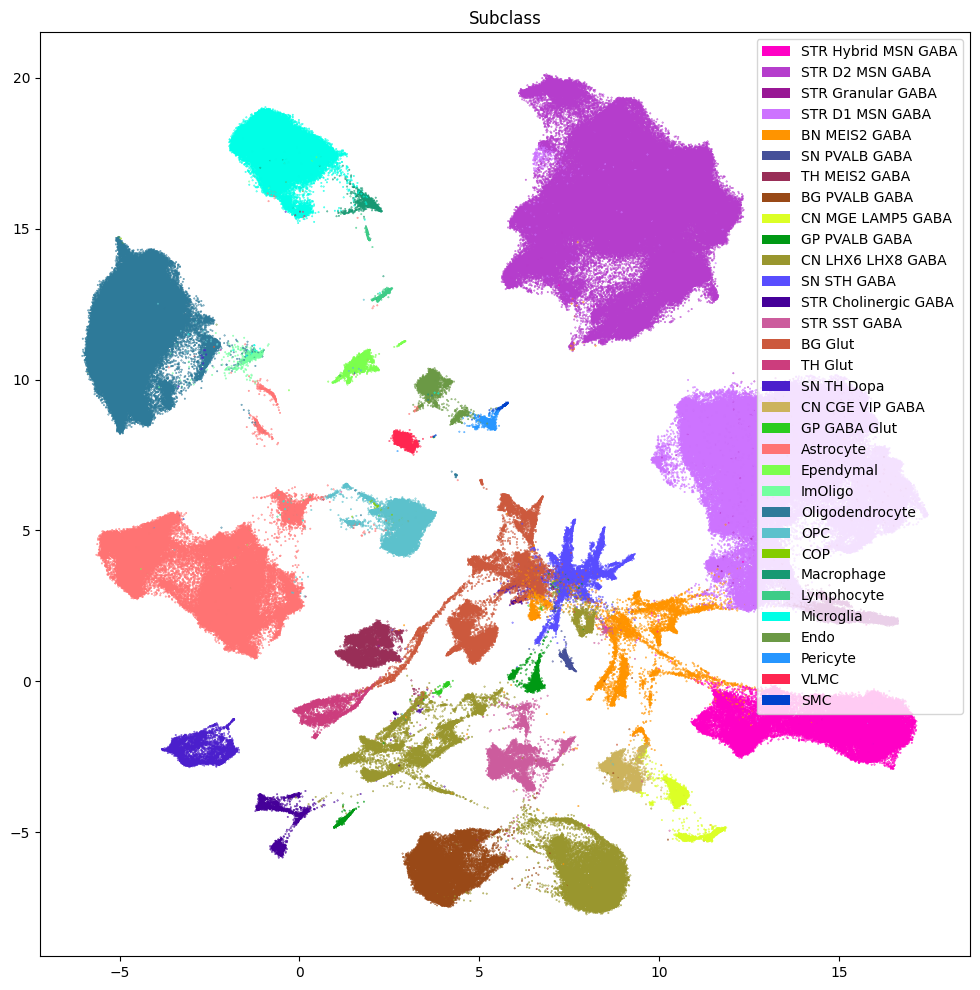

In [36]:
fig, ax = plot_umap(
    cell_with_taxonomy['x'],
    cell_with_taxonomy['y'],
    cc=cell_with_taxonomy['Subclass_color'],
    labels=cell_with_taxonomy['Subclass'],
    term_orders=cell_with_taxonomy['Subclass_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Subclass")
plt.show()

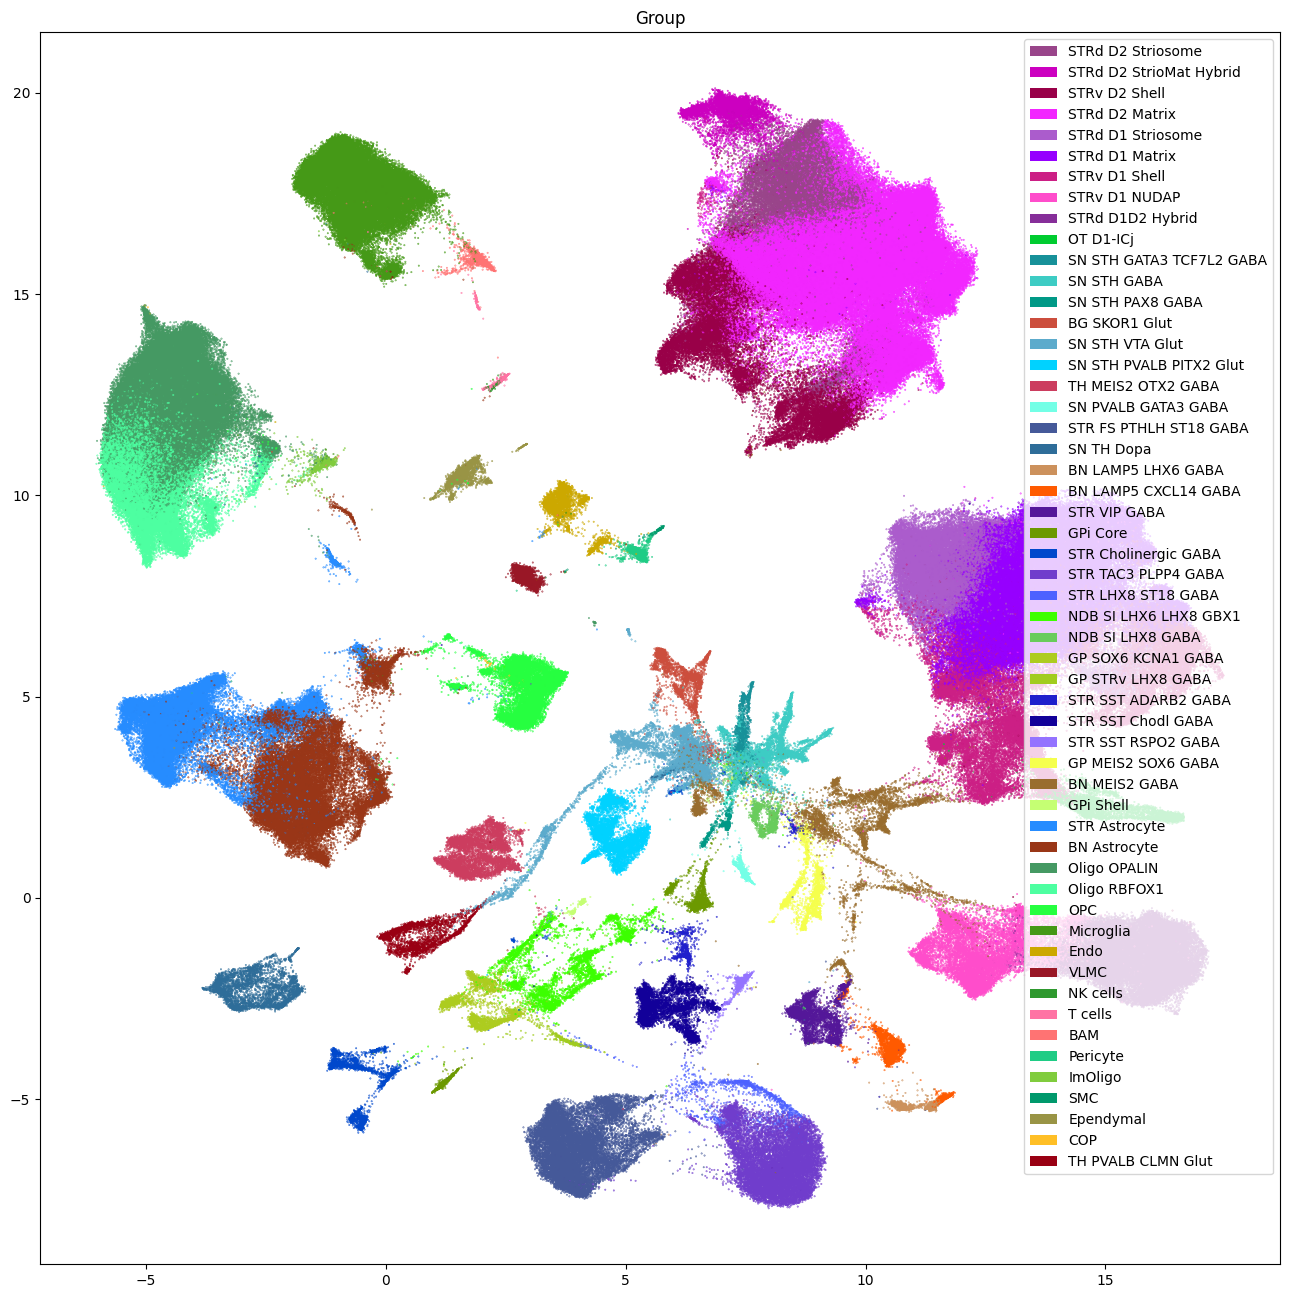

In [37]:
fig, ax = plot_umap(
    cell_with_taxonomy['x'],
    cell_with_taxonomy['y'],
    cc=cell_with_taxonomy['Group_color'],
    labels=cell_with_taxonomy['Group'],
    term_orders=cell_with_taxonomy['Group_order'],
    fig_width=16,
    fig_height=16
)
res = ax.set_title("Group")
plt.show()

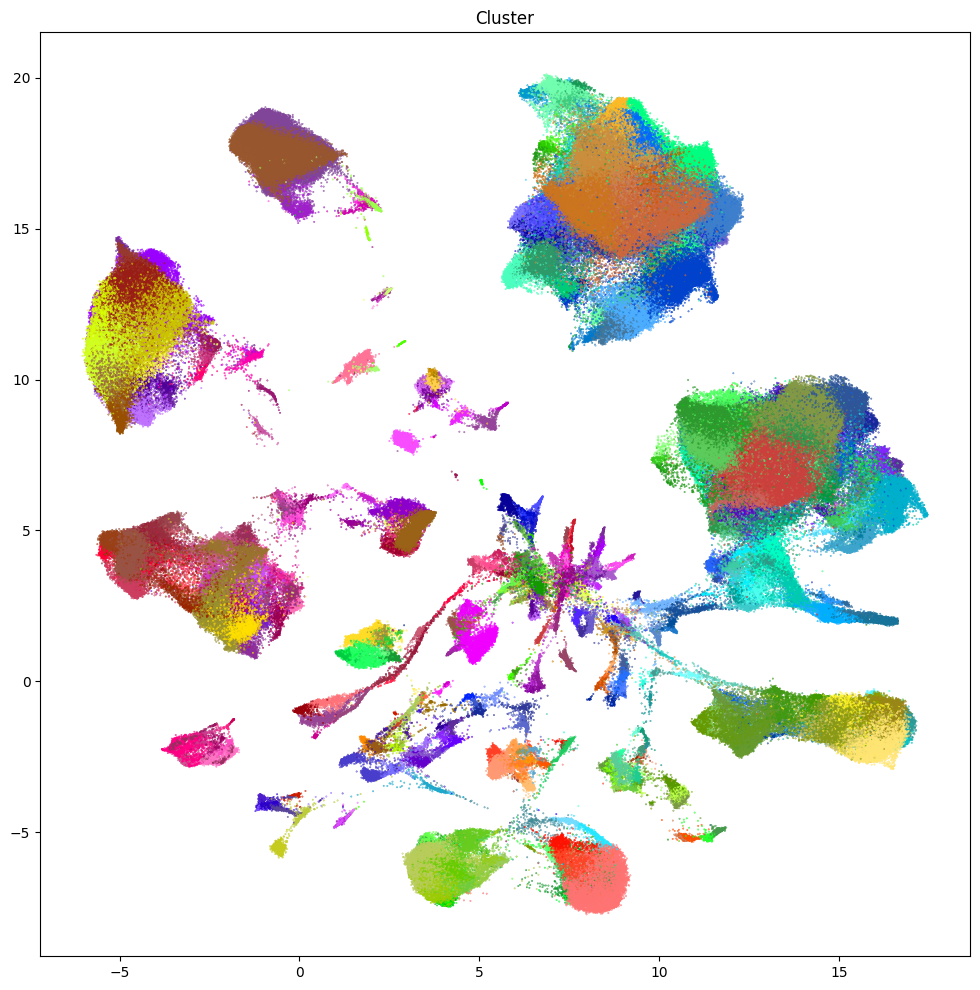

In [38]:
fig, ax = plot_umap(
    cell_with_taxonomy['x'],
    cell_with_taxonomy['y'],
    cc=cell_with_taxonomy['Cluster_color'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("Cluster")
plt.show()

### Aggregating cluster and cells counts per term

Let's investigate the taxonomy information a bit more. In this section, we'll create bar plots showing the number of clusters and cells at each level in the taxonomy. 

First, we need to compute the number of clusters that are in each of the celltype taxons above it.

In [39]:
# Count the number of clusters associated with each cluster annotation term
term_cluster_count = membership_with_cluster_info.reset_index().groupby(['cluster_annotation_term_label'])[['cluster_alias']].count()
term_cluster_count.columns = ['number_of_clusters']
term_cluster_count.head()

number_of_clusters
cluster_annotation_term_label                    
CS20241031_CLASS_0000                         191
CS20241031_CLASS_0001                         189
CS20241031_CLASS_0002                          19
CS20241031_CLASS_0003                          49
CS20241031_CLASS_0004                          13

We already have our number of cells computed previously, so we'll just use them here and cluster counts into the cluster_annotation table.

In [40]:
# Join counts with the term dataframe
term_with_counts = cluster_annotation_term_with_cells.join(term_cluster_count)
term_with_counts[['name', 'cluster_annotation_term_set_name', 'number_of_clusters', 'number_of_cells']].head(5)

name  \
cluster_annotation_term_label                    
CS20241031_NEIGH_0000          Subpallium GABA   
CS20241031_NEIGH_0001           Glut Sero Dopa   
CS20241031_NEIGH_0002                GABA Glut   
CS20241031_NEIGH_0003                Nonneuron   
CS20241031_CLASS_0000              CN MGE GABA   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20241031_NEIGH_0000                             Neighborhood   
CS20241031_NEIGH_0001                             Neighborhood   
CS20241031_NEIGH_0002                             Neighborhood   
CS20241031_NEIGH_0003                             Neighborhood   
CS20241031_CLASS_0000                                    Class   

                               number_of_clusters  number_of_cells  
cluster_annotation_term_label                                       
CS20241031_NEIGH_0000                         399           458635  
CS20241031_NEIGH_0001                          62            22134  
CS20241031_NEIGH_0002                           3              509  
CS20241031_NEIGH_0003                         103           225699  
CS20241031_CLASS_0000                         191            78954

Below we create a function to plot the cluster and cell counts in a bar graph, coloring by the associated taxon level.

In [41]:
def bar_plot_by_level_and_type(df, level, fig_width = 8.5, fig_height = 4):
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(fig_width, fig_height)
    
    for idx, ctype in enumerate(['clusters', 'cells']):

        pred = (df['cluster_annotation_term_set_name'] == level)
        names = df[pred]['name']
        counts = df[pred]['number_of_%s' % ctype]
        colors = df[pred]['color_hex_triplet']
        
        ax[idx].barh(names, counts, color=colors)
        ax[idx].set_title('Number of %s by %s' % (ctype,level)),
        ax[idx].set_xscale('log')
        
        if idx > 0:
            ax[idx].set_yticklabels([])

    plt.show()

Now let's plot the counts for each of the taxonomy levels above Cluster.

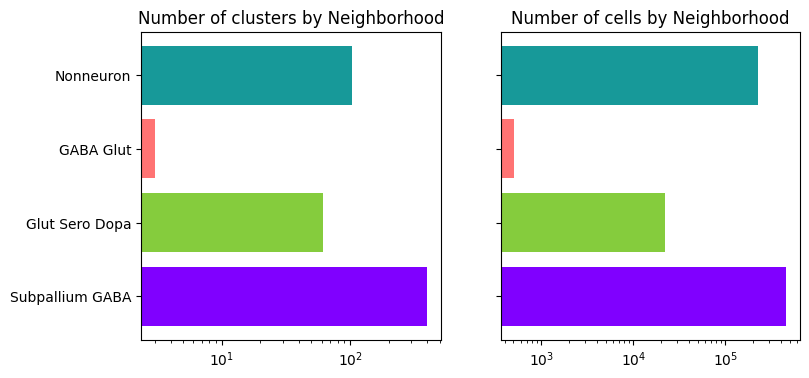

In [42]:
bar_plot_by_level_and_type(term_with_counts, 'Neighborhood')
plt.show()

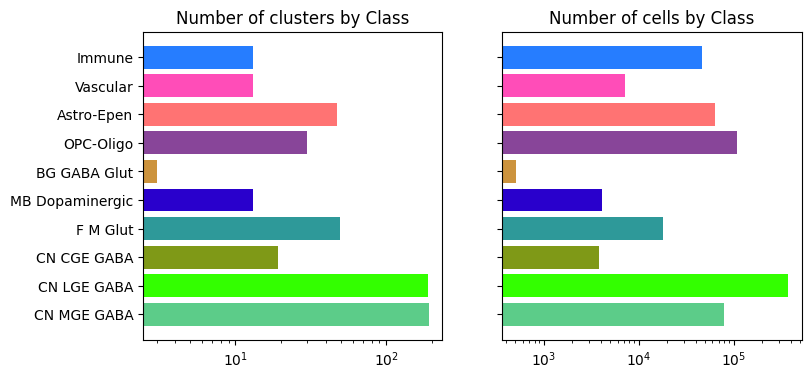

In [43]:
bar_plot_by_level_and_type(term_with_counts, 'Class')
plt.show()

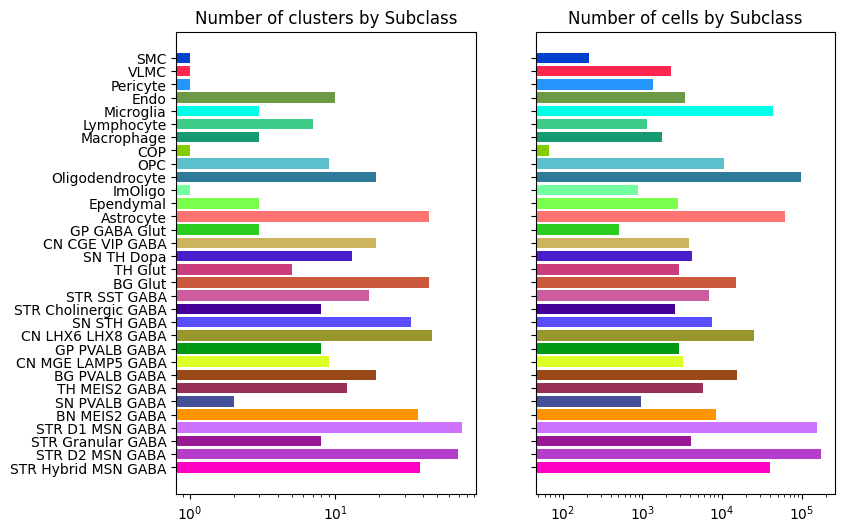

In [44]:
bar_plot_by_level_and_type(term_with_counts, 'Subclass', 8.5, 6)
plt.show()

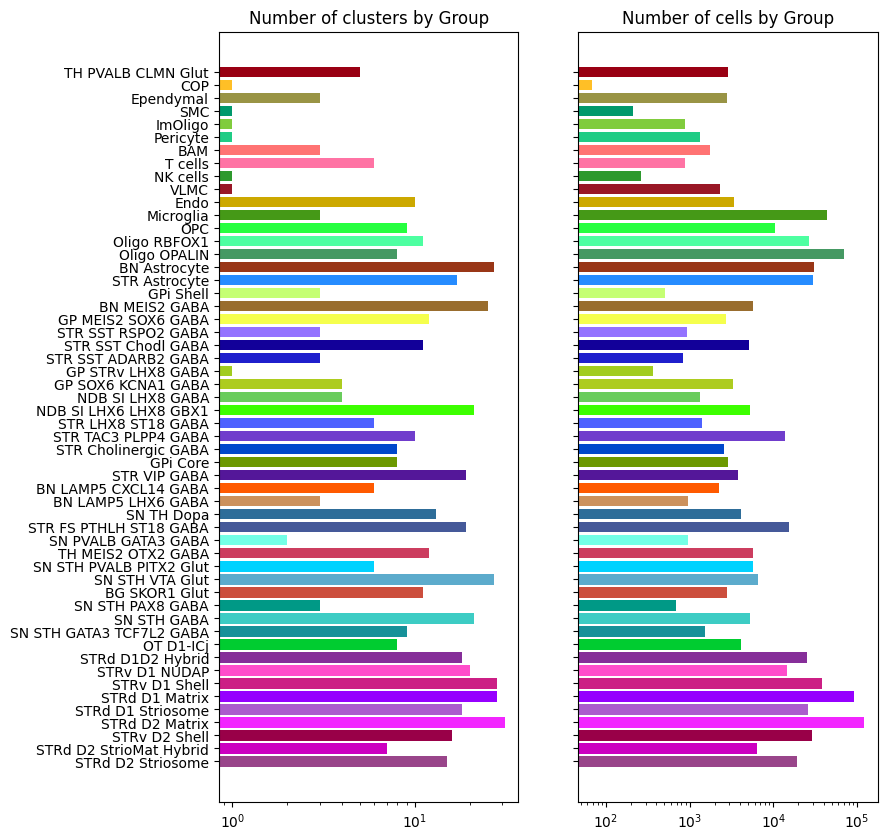

In [45]:
bar_plot_by_level_and_type(term_with_counts, 'Group', 8.5, 10)
plt.show()

#### Distribution of lower taxonomy levels in their parents.

We can also use a similar visualization to show a given taxonomy level in another. Below we define functions to manipulate our data and plot the stacked bar plot.

In [46]:
def distribution(A, B):
    
    AxB = cluster_details.groupby([A, B])[['Cluster']].count()
    AxB.columns = ['number_of_clusters']
    AxB = AxB.unstack().fillna(0)

    B_names = [x[1] for x in list(AxB.columns)]
    pred = (cluster_annotation_term_with_cells['cluster_annotation_term_set_name'] == B)
    term_by_name = cluster_annotation_term_with_cells[pred].set_index('name')
    B_colors = term_by_name.loc[B_names, 'color_hex_triplet']
    
    return AxB, B_names, B_colors

In [47]:
def stacked_bar_distribution(AxB, B_names, B_colors, fig_width = 6, fig_height = 6):

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    bottom = np.zeros(len(AxB))

    for i, col in enumerate(AxB.columns):
        ax.barh(AxB.index, AxB[col], left=bottom, label=col[1], color=B_colors[i])
        bottom += np.array(AxB[col])

    ax.set_title('Distribution of %s in each %s' % (AxB.columns.names[1], AxB.index.name))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
    return fig, ax

We can now visualize how each lower level in the taxonomy is distributed by cluster in the upper portions of the taxonomy.

/tmp/ipykernel_29783/1772253940.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.barh(AxB.index, AxB[col], left=bottom, label=col[1], color=B_colors[i])


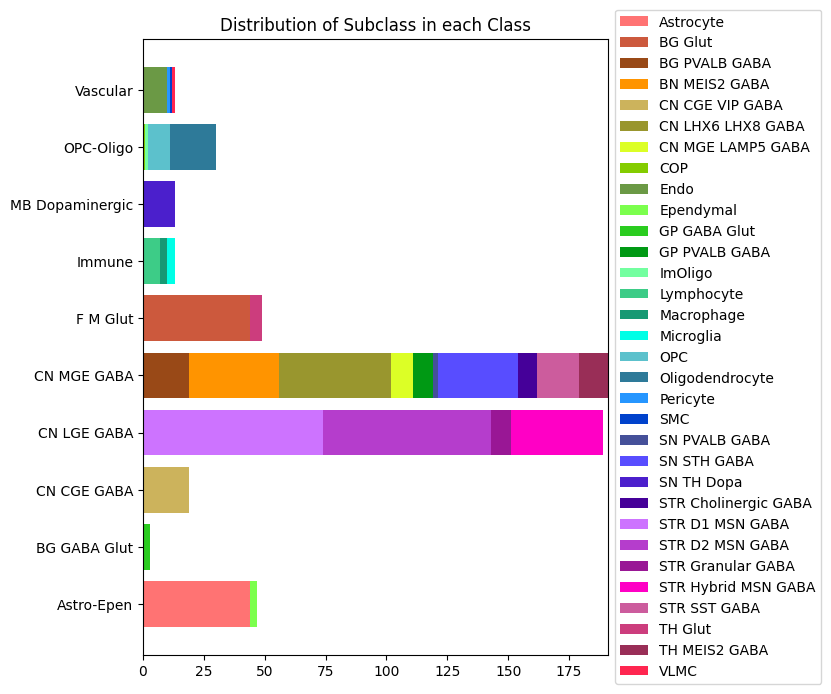

In [48]:
AxB, B_names, B_colors = distribution('Class', 'Subclass')
fig, ax = stacked_bar_distribution(AxB, B_names, B_colors, 6, 8)
plt.show()

### Visualizing the human whole brain taxonomy

Term sets: Class, Subclasss, Group and Cluster forms a four level Basil Ganglia taxonomy. We can visualize the taxonomy as a sunburst diagram that shows the single inheritance hierarchy through a series of rings, that are sliced for each annotation term. Each ring corresponds to a level in the hierarchy. We have ordered the rings so that the Class level is the outer most ring so that we can add in labels. Rings are sliced up and divided based on their hierarchical relationship to the parent slice. The angle of each slice is proportional to the number of clusters belonging to the term. Note that we exlude Neighborhood here as it is a much less interesting plot.

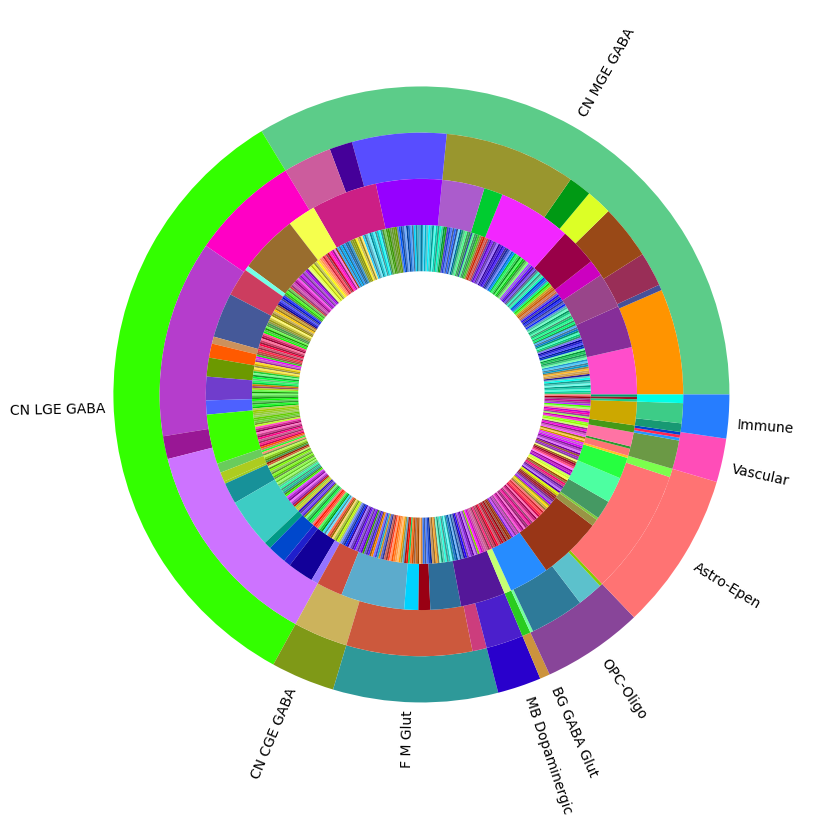

In [49]:
levels = ['Class', 'Subclass', 'Group', 'Cluster']
df = {}

reset_term_with_counts = term_with_counts.reset_index()
for lvl in levels :
    pred = reset_term_with_counts['cluster_annotation_term_set_name'] == lvl
    df[lvl] = reset_term_with_counts[pred]
    df[lvl] = df[lvl].sort_values(['parent_term_label', 'cluster_annotation_term_label'])

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
size = 0.15

for i, lvl in enumerate(levels):
    
    if lvl == 'Class':
        ax.pie(df[lvl]['number_of_clusters'],
               colors=df[lvl]['color_hex_triplet'],
               labels = df[lvl]['name'],
               rotatelabels=True,
               labeldistance=1.025,
               radius=1,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)
    else :
        ax.pie(df[lvl]['number_of_clusters'],
               colors=df[lvl]['color_hex_triplet'],
               radius=1-i*size,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)

plt.show()